Using RandomWavesFast class
====================================================

In this notebook, we describe how we can generate random waves in an optimised manner using the RandomWavesFast. We load the RandomWaves and RandomWavesFast class for generating the same wave field time series, using 2000 frequencies for both classes and subsequently we generate the free surface elevation and / or velocities using both classes. We check the fidelity of the reconstruction and we compare computational times.  

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import sys
#Append path of local proteus installation
sys.path.append("D:/Work/My repos/proteus/")
sys.path.append("D:/Work/My repos/proteus/proteus")
#The notebook will work with the following commit:
#https://github.com/erdc-cm/proteus/commit/9bb34b3563b5ddab6cb1dd9f75173da2710d2a41
import imp
#WT = imp.load_source('WaveTools', 'D:/Work/My repos/proteus/proteus/WaveTools.py')
from proteus import WaveTools as WT
import time 
#from proteus import WaveTools as WT

Tp = 2.
Hs = 0.05
mwl = 1.
depth = 1.
g = np.array([0., -9.81, 0])
N = 500
bandFactor = 2.
spectName = "JONSWAP"
spectral_params = None
waveDir = np.array([1., 0., 0.])

phi = 2.0*3.14159*np.random.random(N)


Calling RandomWaves and RandomWavesFast class to generate the free surface elevation and velocities

In [2]:
%tb


RW = WT.RandomWaves(Tp,
                 Hs,
                 mwl,
                 depth,
                 waveDir,
                 g,
                 N,
                 bandFactor,
                 spectName,
                 spectral_params,
                 phi
                )
nperiod = 25
npoints = 25
n = npoints * nperiod
tnlist=np.linspace(0,nperiod*Tp,n)
xlist=np.zeros((25,3),)
xlist[:,0]=np.linspace(0,5,25)
Lgen =np.array([5.,0.,0.])



RW_Fast = WT.RandomWavesFast(tnlist[0],
                            500,
                            xlist[0],
                            Tp,
                            Hs,
                            mwl,#m significant wave height
                            depth , #m depth
                            waveDir,
                            g, #peak frequency
                            N,
                            bandFactor, #accelerationof gravity
                            spectName ,# random words will result in error and return the available spectra
                            spectral_params, #JONPARAMS = {"gamma": 3.3, "TMA":True,"depth": depth}
                            phi,
                            Lgen = Lgen,
                            Nfreq = 32,
                            Nwaves = 14)

No traceback available to show.


In [3]:
wind = RW_Fast.windOut()
print (wind)
print (wind["TWindow"])
print (wind["TOverlap"])
print (wind["Tlag"])

eta_t = np.zeros((len(tnlist),len(xlist)),)


t1  =-time.clock()
for j in range(len(xlist)):
    for i in range(len(tnlist)):
        t = tnlist[i]
        x = xlist[j]
        eta_t[i,j] = RW.eta(x, t)
t1 = t1 + time.clock()

eta_ts = eta_t.copy()

#Calculating time series
t2 = -time.clock()
for j in range(len(xlist)):
    for i in range(len(tnlist)):
        t = tnlist[i]
        x = xlist[j]
        eta_ts[i,j] = RW_Fast.eta(x, t)
t2 = t2 +  time.clock()




{'TWindow': 25.769743889322932, 'TOverlap': 18.03882072252605, 'Tlag': 3.977768097516751, 'rec_direct': False}
25.769743889322932
18.03882072252605
3.977768097516751


/home/jovyan/proteus/linux/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # Remove the CWD from sys.path while we load stuff.
/home/jovyan/proteus/linux/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  app.launch_new_instance()
/home/jovyan/proteus/linux/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/home/jovyan/proteus/linux/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.pro

Next, we compare the two generated time series in terms of data and execution time

0.00013519054051139585
0.0008770896523360291


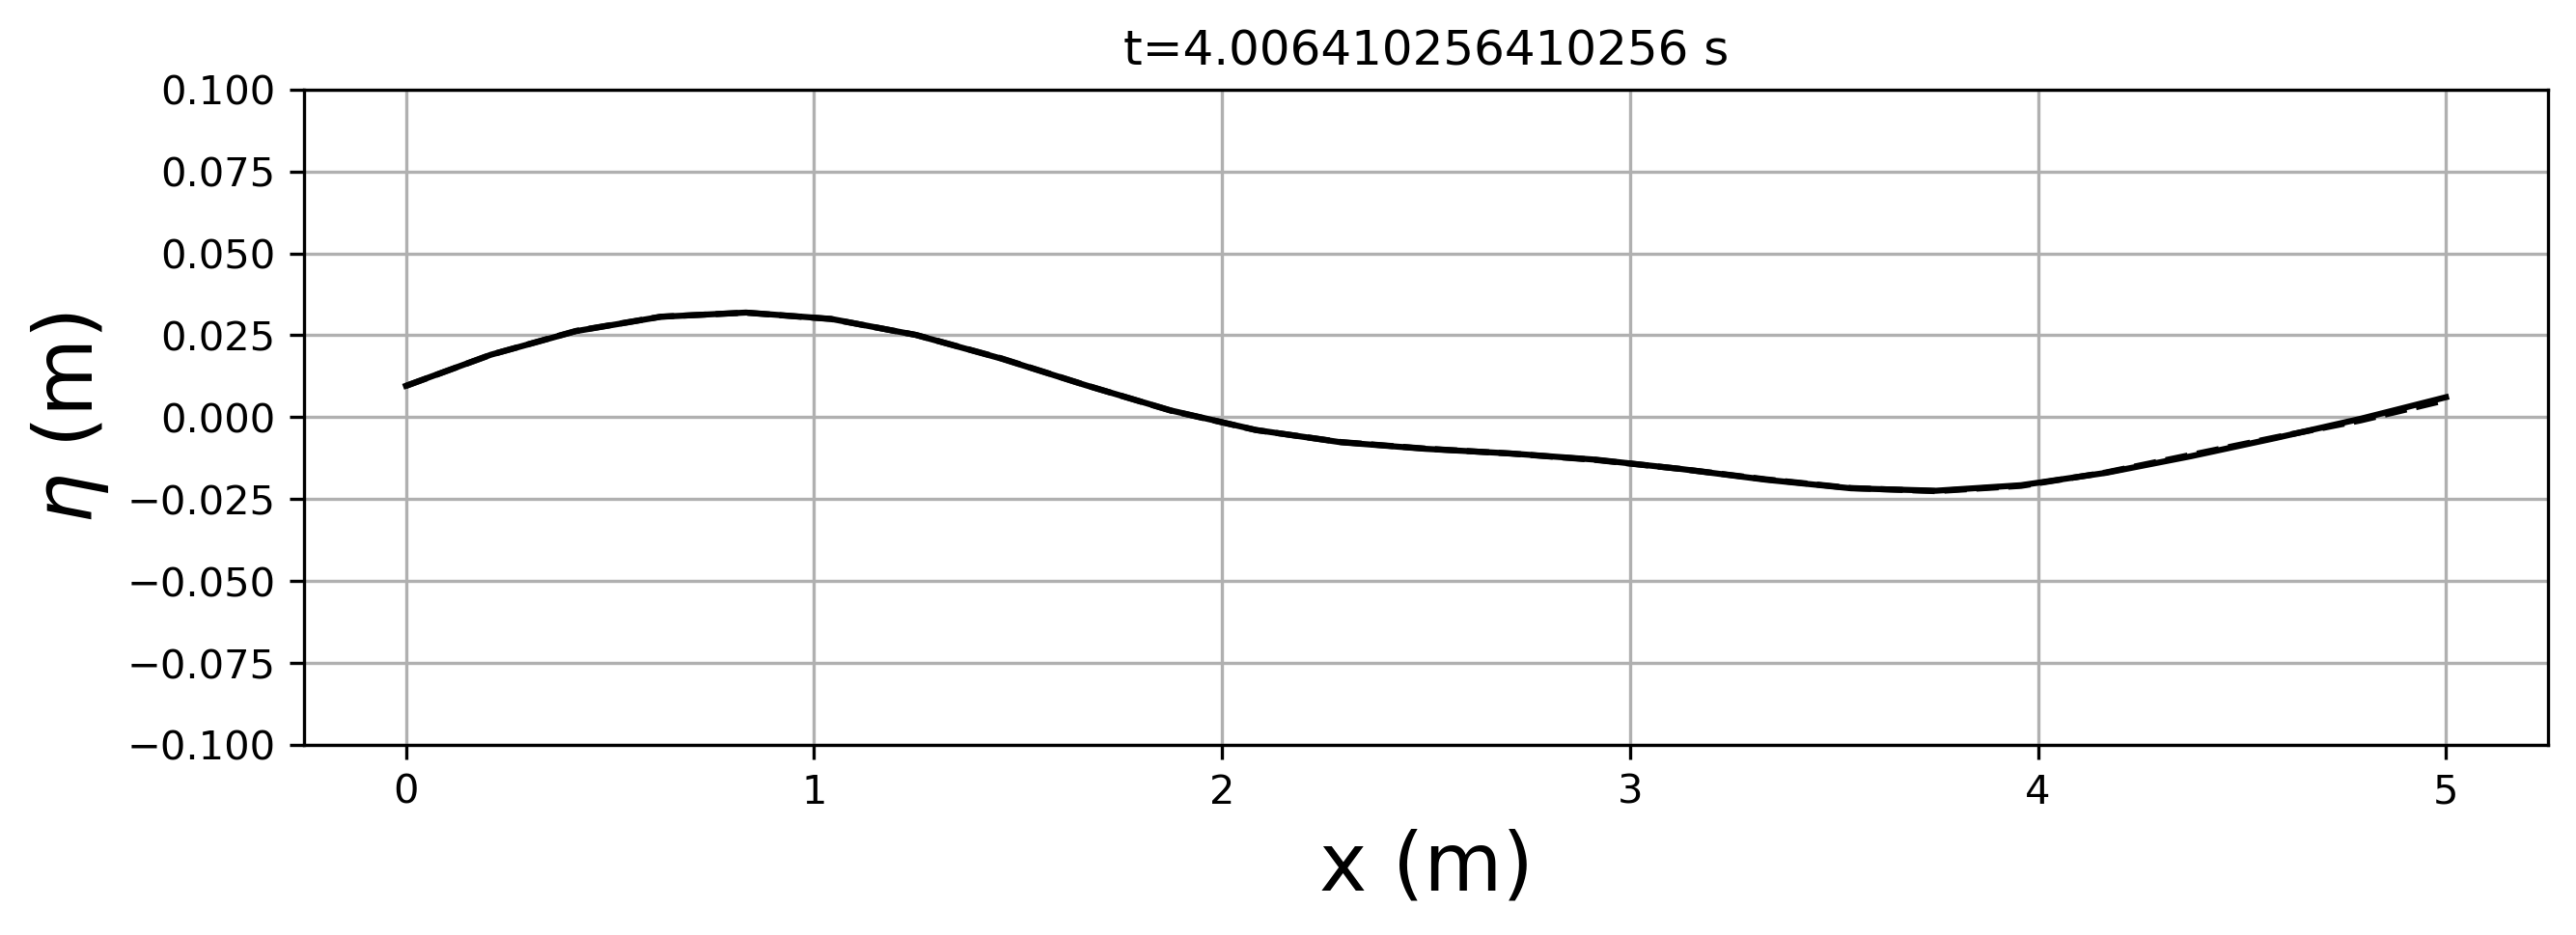

10.109422423039307


In [4]:
#Plotting both time series from time series file and wave class
ii = np.where(tnlist>11)[0][0]
psize = 20
import time, sys
from IPython.display import clear_output
aa = 0.
bb =0.
for i in range(0,len(tnlist),1):
    err = (eta_t[i,:] - eta_ts[i,:])**2/len(eta_t)
    err2 = max(abs(eta_t[i,:] - eta_ts[i,:]))
    bb = max(err2,bb)
    err = sum(np.sqrt(err))
    aa = max(err,aa)

maxa = abs(eta_t - eta_ts)
ik,j = np.unravel_index(maxa.argmax(), maxa.shape)
plt.figure(0, figsize=(10,3), dpi=300)
plt.grid()
plt.plot(xlist[:,0], eta_t[ik,:], color='black', label="RandomWaves")
plt.plot(xlist[:,0], eta_ts[ik,:], "k--", label="RandomWavesFast")
plt.ylim(-0.1,0.1)
plt.title("t="+str(tnlist[ik])+" s")
plt.xlabel("x (m)", fontsize = psize)
plt.ylabel("$\eta$ (m)",fontsize = psize)
plt.savefig("Freesurface2"+str(wind["TOverlap"]/(wind["TWindow"]))+".pdf" )  
    
print (aa)
print (bb)
plt.show()
    
print (t1/t2)

In [5]:
windows = RW_Fast.windows
ci = min(RW_Fast.ci)
ho = RW_Fast.ho
Lgen = 5.
Tlag = Lgen/ci
print (Tlag)
plt.close("all")
from IPython.display import HTML
from matplotlib import animation, rc
fig, ax = plt.subplots(figsize=(12,4.5))
ax.set_xlim(( -5, 30))
ax.set_ylim((-0.05, 0.05))
plt.grid()
line0 = ax.plot(windows[0][:,0],windows[0][:,1],label="Window 1")
line1 = ax.plot(windows[1][:,0],windows[1][:,1],"k--",label="Window 2")
line2 = ax.plot(windows[2][:,0],windows[2][:,1],"r-.",label="Window 3")
line3 = ax.plot(windows[2][:,0],windows[2][:,1],"y-.",label="Window 4")

ax.legend()
line, = ax.plot([], [], "ko-",lw=2)
line4 = ax.plot([ho[0],ho[0]],[-1000,1000],"g-")
line4 = ax.plot([ho[1],ho[1]],[-1000,1000],"g-")
line4 = ax.plot([ho[2],ho[2]],[-1000,1000],"g-")


text1 = ax.text(0-Tlag,0.03,"")
text2 = ax.text(0,0.03,"")


AttributeError: 'RandomWavesFast' object has no attribute 'ci'

In [6]:
def init():
    line.set_data([], [])
    text1.set_text("1")
    text2.set_text("1")
    return (line,)

In [7]:
# animation function. This is called sequentially
def animate(i):
    i = 0.25*i 
    x = [i-Tlag,i]
    y = [0.025,0.025]
    line.set_data(x, y)
    text1.set_text(str(1+RW_Fast.fW(i-Tlag)))
    text2.set_text(str(1+RW_Fast.fW(i)))
    text1.set_x(i-Tlag)
    text2.set_x(i)

    return (line,)

In [8]:
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=200, blit=True)
sys.path.append("D:/Work/ffmpeg/ffmpeg-20160831-99882d0-win64-static/bin/")
plt.rcParams['animation.writer']='ffmpeg'
plt.rcParams['animation.ffmpeg_path'] ="D:/Work/ffmpeg/ffmpeg-20160831-99882d0-win64-static/bin/ffmpeg.exe"
rc('animation', html='html5')
anim


NameError: name 'animation' is not defined